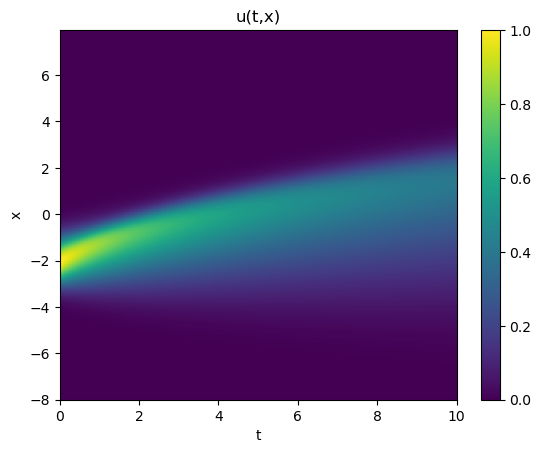

In [293]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

import numpy as np

data = np.load('1.npz')
lst = data.files

u = data['u']
x = data['x']
t = data['t']

x = x[:, 0]  #  shape (101,)
t = t[0, :]  #  shape (256,)
# print(u.shape) # u (x, t)
# print(x.shape) # x is 256
# print(t.shape) # t i 101

dt = t[1] - t[0]
dx = x[1] - x[0]
# print(dt)
# print(dx)

# numerical approximation of u_t
u_t = np.zeros_like(u)
for i in range(1, len(t) - 1):
    u_t[:, i] = (u[:, i+1] - u[:, i-1]) / (2 * dt)
u_t[:, 1] = (u[:, 1] - u[:, 0]) / dt
u_t[:, -1] = (u[:, -1] - u[:, -2]) / dt

# numerical approximation of u_x
u_x =  np.zeros_like(u)
for i in range(1, len(x) - 1):
    u_x[i,:] = (u[i+1, :] - u[i-1, :]) / (2 * dx)
u_x[0, :] = (u[1, :] - u[0, :]) / dx
u_x[-1, :] = (u[-1, :] - u[-2, :]) / dx

# numerical approximation of u_xx
u_xx =  np.zeros_like(u)
for i in range(1, len(x) - 1):
    u_xx[i, :] = (u[i+1, :] - 2 * u[i, :] + u[i-1, :]) / dx**2
u_xx[0, :] = (u[1, :] - 2 * u[0, :] + u[0, :]) / dx**2
u_xx[-1, :] = (u[-1, :] - 2 * u[-1, :] + u[-2, :]) / dx**2

# numerical approximation of u_xxx
u_xxx =  np.zeros_like(u)
for i in range(1, len(x) - 1):
    u_xxx[i, :] = (u[i+1, :] - 3 * u[i, :] + 3 * u[i-1, :] - u[i-2, :]) / dx**3
u_xxx[0, :] = (u[1, :] - 3 * u[0, :] + 3 * u[0, :] - u[0, :]) / dx**3
u_xxx[-1, :] = (u[-1, :] - 3 * u[-1, :] + 3 * u[-2, :] - u[-3, :]) / dx**3


# generate a heat map to display u(t,x) with the correct axis labels    
plt.imshow(u, aspect='auto', origin= 'lower', extent=[t[0], t[-1], x[0], x[-1]])
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('u(t,x)')
plt.show()





In [294]:
x_slice = slice(1, -1)  # use interior points in space
t_slice = slice(1, -1)  # similarly for time
X, T = np.meshgrid(x[x_slice], t[t_slice], indexing='ij')

# Flatten the data
Ut_flat = u_t[x_slice, t_slice].reshape(-1, 1)   # shape (N, 1)
U_flat = u[x_slice, t_slice].reshape(-1, 1)
Ux_flat = u_x[x_slice, t_slice].reshape(-1, 1)
Uxx_flat = u_xx[x_slice, t_slice].reshape(-1, 1)
Uxxx_flat = u_xxx[x_slice, t_slice].reshape(-1, 1)
X_flat = X.reshape(-1, 1)
T_flat = T.reshape(-1, 1)

#  Build the dictionary (Theta)
Theta = np.hstack([ 
    np.ones_like(U_flat),     # Constant term
    U_flat,                   # u
    Ux_flat,                  # u_x
    Uxx_flat,                 # u_xx
    Uxxx_flat,                # u_xxx
    U_flat**2,                # u^2
    U_flat * Ux_flat,         # u * u_x
    U_flat * Uxx_flat,        # u * u_xx
    U_flat * Uxxx_flat,       # u * u_xxx
    Ux_flat * Uxx_flat,       # u_x * u_xx
    Ux_flat * Uxxx_flat,      # u_x * u_xxx
    Uxx_flat * Uxxx_flat      # u_xx * u_xxx
    
])

# Labels for reference 
terms = ['1' ,'u', 'u_x', 'u_xx', 'u_xxx', 'u^2', 'u * u_x', 'u * u_xx', 'u * u_xxx', 'u_x * u_xx', 'u_x * u_xxx', 'u_xx * u_xxx']

#  initial ridge
alpha = 1e-5  
ridge = Ridge(alpha=alpha, fit_intercept=False)
ridge.fit(Theta, Ut_flat)

Xi = ridge.coef_.ravel()
print("Initial coefficients:")
for term, coeff in zip(terms, Xi):
    print(f"{term}: {coeff}")

# Thresholding to promote sparsity
def threshold_coeffs(Xi, threshold):
    # Set coefficients smaller than threshold in absolute value to zero
    Xi[np.abs(Xi) < threshold] = 0
    return Xi

threshold = 1e-2  
Xi_old = Xi.copy()
for _ in range(10):  # 10 iterations of thresholding
    Xi = threshold_coeffs(Xi, threshold)
    # Refit only with non-zero coefficients
    keep_terms = Xi != 0
    if np.sum(keep_terms) == 0:
        break
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(Theta[:, keep_terms], Ut_flat)
    Xi_new = np.zeros_like(Xi)
    Xi_new[keep_terms] = ridge.coef_.ravel()
    #  convergence
    if np.allclose(Xi_new, Xi, atol=1e-8):
        break
    Xi = Xi_new

print("\nCoefficients after thresholding:")
for term, coeff in zip(terms, Xi):
    print(f"{term}: {coeff}")


Initial coefficients:
1: 2.9945433198008686e-05
u: -0.00045260117622092366
u_x: 0.0028659452218562365
u_xx: 0.09975672513246536
u_xxx: 0.0006365980370901525
u^2: -0.004389317240566015
u * u_x: -0.9866628050804138
u * u_xx: -0.022585583850741386
u * u_xxx: 0.008483986370265484
u_x * u_xx: -0.014766660518944263
u_x * u_xxx: 0.003987294156104326
u_xx * u_xxx: 0.0004008970863651484

Coefficients after thresholding:
1: 0.0
u: 0.0
u_x: 0.0
u_xx: 0.09951372444629669
u_xxx: 0.0
u^2: 0.0
u * u_x: -1.0027563571929932
u * u_xx: 0.0
u * u_xxx: 0.0
u_x * u_xx: 0.0
u_x * u_xxx: 0.0
u_xx * u_xxx: 0.0


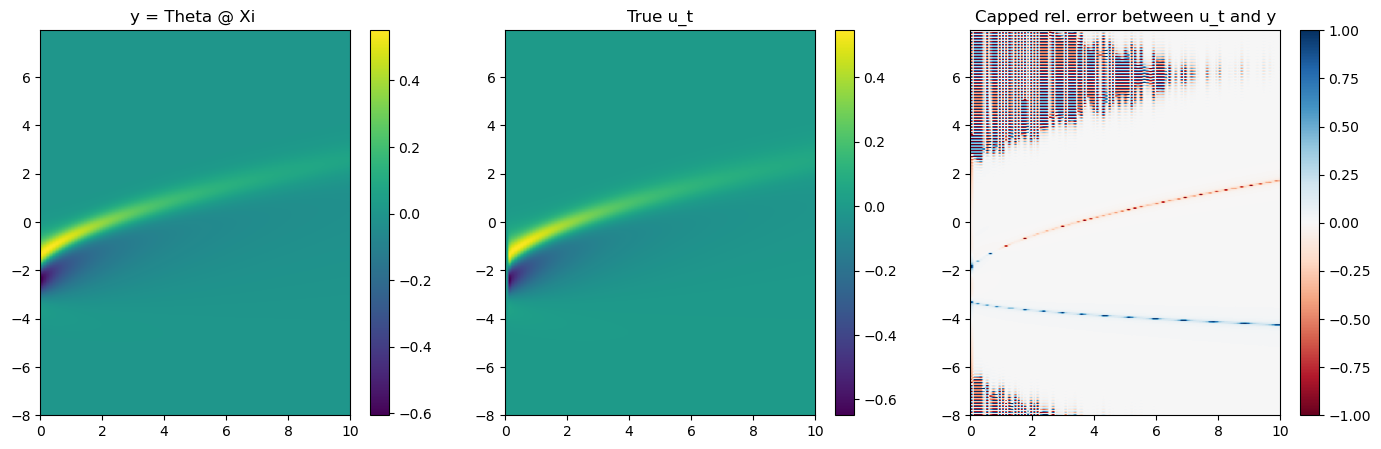

In [280]:

# generate a heat map to display y = theta @ Xi  to compare it with u_t
y = Theta @ Xi
y = y.reshape(X.shape)

fig, axs = plt.subplots(1, 3, figsize=(17, 5))
im0 = axs[0].imshow(y, aspect='auto',origin= 'lower', extent=[t[0], t[-1], x[0], x[-1]])
axs[0].set_title('y = Theta @ Xi ')
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(u_t, aspect='auto',origin= 'lower', extent=[t[0], t[-1], x[0], x[-1]])
axs[1].set_title('True u_t')
fig.colorbar(im1, ax=axs[1])
#plt.show()


u_t_sliced = u_t[x_slice, t_slice]
# compute relative error and cap it at 1
rel_l2_capped_at_1 = np.minimum(np.abs((u_t_sliced - y)/(u_t_sliced + 1e-12)), 1) * np.sign(u_t_sliced - y)
# this plot shows us where we are off, not how much we are off
im2 = axs[2].imshow(rel_l2_capped_at_1,
           aspect='auto',
           origin= 'lower',
           extent=[t[0], t[-1], x[0], x[-1]],
           cmap='RdBu',    # Set red-blue diverging colormap
           vmin=-1,        # Set minimum of color scale
           vmax=1)         # Set maximum of color scale
axs[2].set_title('Capped rel. error between u_t and y')
fig.colorbar(im2, ax=axs[2])


plt.show()


In [281]:
# print the L2 error of the regression:
l2_error = np.linalg.norm(u_t_sliced - y) 
rel_l2_error = l2_error/np.linalg.norm(u_t_sliced)
print("relative error:", rel_l2_error)
print(f"L2 error: {l2_error}")

print("PDE:")
print("u_t = ", end='')
for term, coeff in zip(terms, Xi):
    if coeff != 0:
        print(f"({coeff}) {term} + ", end='')
print("\b\b\b\b") 



relative error: 0.028756948
L2 error: 0.29517239332199097
PDE:
u_t = (0.09951372444629669) u_xx + (-1.0027563571929932) u * u_x 


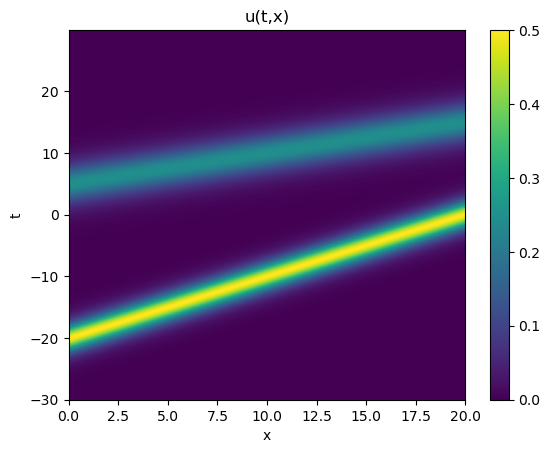

In [295]:
# data2

data = np.load('2.npz')
lst = data.files

u = data['u']
x = data['x']
t = data['t']

x = x[:, 0]  #  shape (101,)
t = t[0, :]  #  (256,)

dt = t[1] - t[0]
dx = x[1] - x[0]
# print("dt is ", dt)
# print("dx is ", dx)

# numerical approximation of u_t
u_t = np.zeros_like(u)
for i in range(1, len(t) - 1):
    u_t[:, i] = (u[:, i+1] - u[:, i-1]) / (2 * dt)
u_t[:, 1] = (u[:, 1] - u[:, 0]) / dt
u_t[:, -1] = (u[:, -1] - u[:, -2]) / dt

# numerical approximation of u_x
u_x =  np.zeros_like(u)
for i in range(1, len(x) - 1):
    u_x[i,:] = (u[i+1, :] - u[i-1, :]) / (2 * dx)
u_x[0, :] = (u[1, :] - u[0, :]) / dx
u_x[-1, :] = (u[-1, :] - u[-2, :]) / dx 

# numerical approximation of u_xx
u_xx =  np.zeros_like(u)
for i in range(1, len(x) - 1):
    u_xx[i, :] = (u[i+1, :] - 2 * u[i, :] + u[i-1, :]) / dx**2
u_xx[0, :] = (u[1, :] - 2 * u[0, :] + u[0, :]) / dx**2
u_xx[-1, :] = (u[-1, :] - 2 * u[-1, :] + u[-2, :]) / dx**2

# numerical approximation of u_xxx
u_xxx =  np.zeros_like(u)
for i in range(2, len(x) - 1):
    u_xxx[i, :] = (u[i+1, :] - 3 * u[i, :] + 3 * u[i-1, :] - u[i-2, :]) / dx**3
u_xxx[0, :] = (u[1, :] - 3 * u[0, :] + 3 * u[0, :] - u[0, :]) / dx**3
u_xxx[1, :] = (u[2, :] - 3 * u[1, :] + 3 * u[0, :] - u[0, :]) / dx**3
u_xxx[-1, :] = (u[-1, :] - 3 * u[-1, :] + 3 * u[-2, :] - u[-3, :]) / dx**3


plt.imshow(u, aspect='auto',origin= 'lower', extent=[t[0], t[-1], x[0], x[-1]])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('u(t,x)')
plt.show()







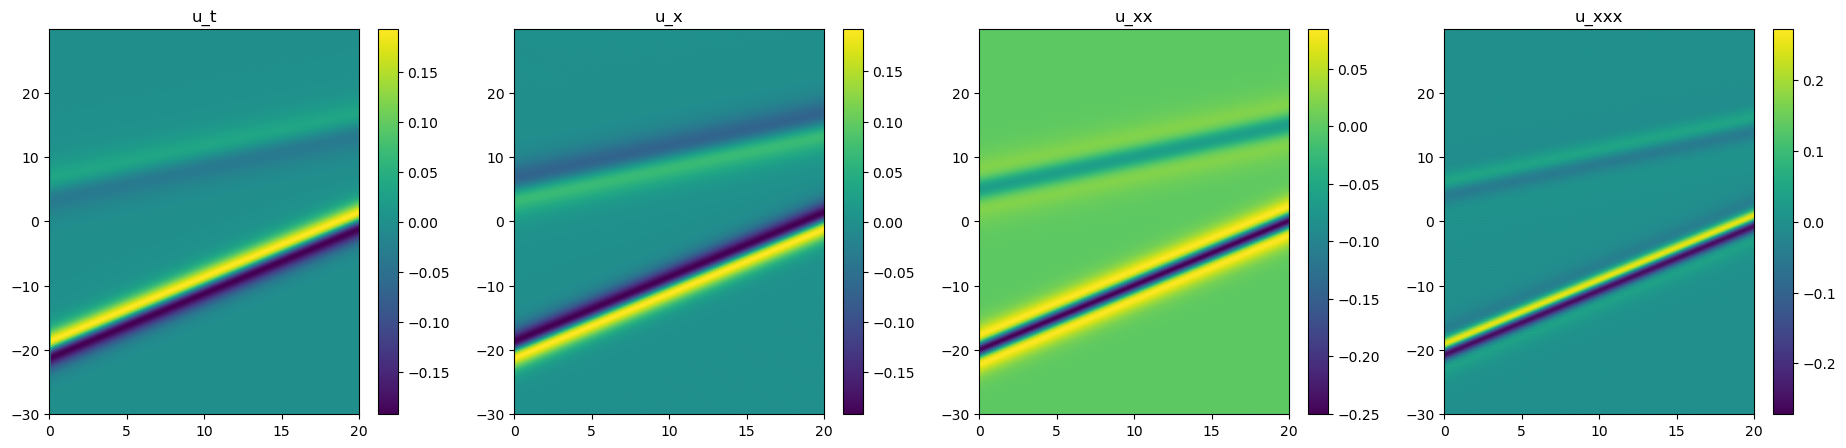

In [283]:
# plot u, u_x, u_xx, u_xxx on four adjacent subplots
fig, axs = plt.subplots(1, 4, figsize=(23, 5))

im0 = axs[0].imshow(u_t, aspect='auto', origin= 'lower', extent=[t[0], t[-1], x[0], x[-1]])
axs[0].set_title('u_t')
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(u_x, aspect='auto', origin= 'lower', extent=[t[0], t[-1], x[0], x[-1]])
axs[1].set_title('u_x')
fig.colorbar(im1, ax=axs[1])
im2 = axs[2].imshow(u_xx, aspect='auto', origin= 'lower', extent=[t[0], t[-1], x[0], x[-1]])
axs[2].set_title('u_xx')
fig.colorbar(im2, ax=axs[2])
im3 = axs[3].imshow(u_xxx, aspect='auto', origin= 'lower', extent=[t[0], t[-1], x[0], x[-1]])
axs[3].set_title('u_xxx')
fig.colorbar(im3, ax=axs[3])
plt.show()


We note that u_xxx and u_x look very very similar (the third derivative is a bit less smooth). In linear regression it is best to avoid using linearly dependent terms so we will avoid using u_xxx in our dictionary. 

In [296]:
x_slice = slice(1, -1)  # use interior points in space
t_slice = slice(1, -1)  # similarly for time
X, T = np.meshgrid(x[x_slice], t[t_slice], indexing='ij')

# flatten the data
Ut_flat = u_t[x_slice, t_slice].reshape(-1, 1)   # shape (N, 1)
U_flat = u[x_slice, t_slice].reshape(-1, 1)
Ux_flat = u_x[x_slice, t_slice].reshape(-1, 1)
Uxx_flat = u_xx[x_slice, t_slice].reshape(-1, 1)
Uxxx_flat = u_xxx[x_slice, t_slice].reshape(-1, 1)
X_flat = X.reshape(-1, 1)
T_flat = T.reshape(-1, 1)

# build the dictionary
Theta = np.hstack([ 
    np.ones_like(U_flat),     # Constant term
    U_flat,                   # u
    Ux_flat,                  # u_x
    Uxx_flat,                 # u_xx
    Uxxx_flat,                # u_xxx
    U_flat**2,                # u^2
    Ux_flat**2,               # u_x^2
    Uxx_flat**2,              # u_xx^2
    Uxxx_flat**2,             # u_xxx^2
    U_flat * Ux_flat,         # u * u_x
    U_flat * Uxx_flat,        # u * u_xx
    U_flat * Uxxx_flat,       # u * u_xxx
    Ux_flat * Uxx_flat,       # u_x * u_xx
    Ux_flat * Uxxx_flat,      # u_x * u_xxx
    Uxx_flat * Uxxx_flat      # u_xx * u_xxx
])

# labels for printing
terms = ['1' ,'u', 'u_x', 'u_xx', 'u_xxx', 'u^2', 'u_x^2', 'u_xx^2', 'u_xxx^2', 'u * u_x', 'u * u_xx', 'u * u_xxx', 'u_x * u_xx', 'u_x * u_xxx', 'u_xx * u_xxx']

# initial ridge
alpha = 1e-1  # HIGH regularization!
ridge = Ridge(alpha=alpha, fit_intercept=False)
ridge.fit(Theta, Ut_flat)

Xi = ridge.coef_.ravel()
print("Initial coefficients:")
for term, coeff in zip(terms, Xi):
    print(f"{term}: {coeff}")


def threshold_coeffs(Xi, threshold):
    # Set coefficients smaller than threshold in absolute value to zero
    Xi[np.abs(Xi) < threshold] = 0
    return Xi

threshold = 1e-1
Xi_old = Xi.copy()
for _ in range(10): 
    Xi = threshold_coeffs(Xi, threshold)
    # Refit only with non-zero coefficients
    keep_terms = Xi != 0
    if np.sum(keep_terms) == 0:
        break
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(Theta[:, keep_terms], Ut_flat)
    Xi_new = np.zeros_like(Xi)
    Xi_new[keep_terms] = ridge.coef_.ravel()
    # Check for convergence
    if np.allclose(Xi_new, Xi, atol=1e-8):
        break
    Xi = Xi_new

print("\nCoefficients after thresholding:")
for term, coeff in zip(terms, Xi):
    print(f"{term}: {coeff}")


Initial coefficients:
1: -7.179161912063137e-05
u: -0.0006034164689481258
u_x: -0.4137529134750366
u_xx: 0.010427207686007023
u_xxx: -0.45002198219299316
u^2: 0.006308148615062237
u_x^2: -0.012377374805510044
u_xx^2: 0.095807284116745
u_xxx^2: -0.062423914670944214
u * u_x: -2.093836545944214
u * u_xx: 0.019973982125520706
u * u_xxx: 0.9858320355415344
u_x * u_xx: -2.4233977794647217
u_x * u_xxx: -0.11253903061151505
u_xx * u_xxx: -0.12864121794700623

Coefficients after thresholding:
1: 0.0
u: 0.0
u_x: -0.41522666811943054
u_xx: 0.0
u_xxx: -0.4474342167377472
u^2: 0.0
u_x^2: 0.0
u_xx^2: 0.0
u_xxx^2: 0.0
u * u_x: -2.0938735008239746
u * u_xx: 0.0
u * u_xxx: 0.9767242074012756
u_x * u_xx: -2.3999035358428955
u_x * u_xxx: 0.0
u_xx * u_xxx: -0.11721797287464142


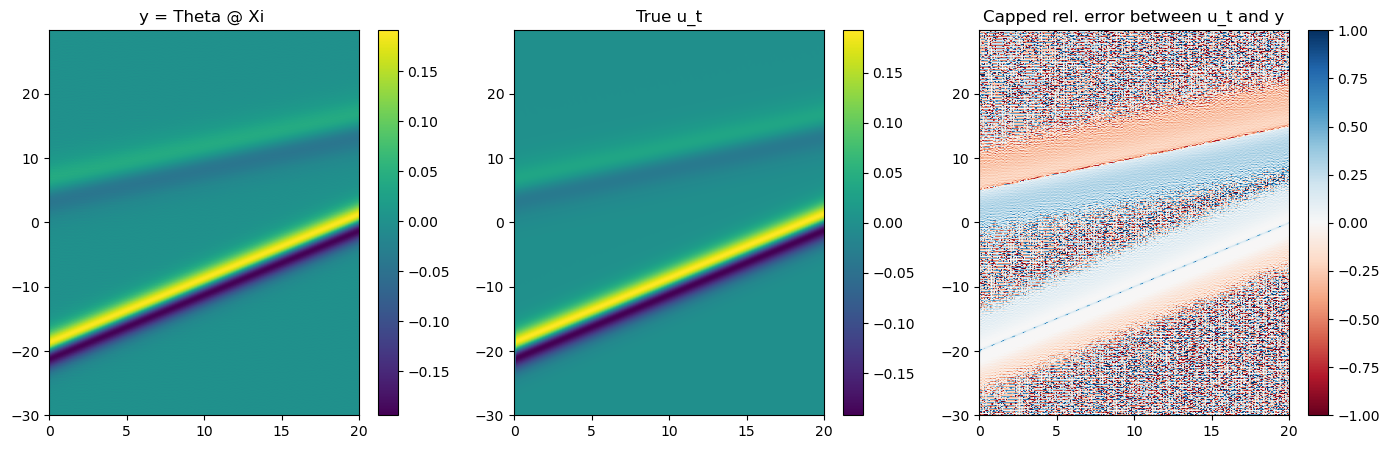

In [297]:

# generate a heat map to display y  to compare it with u_t
y = Theta @ Xi
y = y.reshape(X.shape)

# compare the predicted y with the true u_t on two subplots. use the same colourscale for both plots
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

im0 = axs[0].imshow(y,  aspect='auto', origin= 'lower', extent=[t[0], t[-1], x[0], x[-1]])
axs[0].set_title('y = Theta @ Xi ')
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(u_t, aspect='auto', origin= 'lower', extent=[t[0], t[-1], x[0], x[-1]])
axs[1].set_title('True u_t')
fig.colorbar(im1, ax=axs[1])
#plt.show()


u_t_sliced = u_t[x_slice, t_slice]
rel_l2_capped_at_1 = np.minimum(np.abs((u_t_sliced - y)/(u_t_sliced + 1e-12)), 1) * np.sign(u_t_sliced - y)

im2 = axs[2].imshow(rel_l2_capped_at_1,
           aspect='auto',
           extent=[t[0], t[-1], x[0], x[-1]],
           origin= 'lower',
           cmap='RdBu',    # Set red-blue diverging colormap
           vmin=-1,        # Set minimum of color scale
           vmax=1)         # Set maximum of color scale
axs[2].set_title('Capped rel. error between u_t and y')
fig.colorbar(im2, ax=axs[2])


plt.show()

In [286]:
# print the L2 error of the regression:
l2_error = np.linalg.norm(u_t_sliced - y) 
rel_l2_error = l2_error/np.linalg.norm(u_t_sliced)
print("relative error:", rel_l2_error)
print(f"L2 error: {l2_error}")

print("PDE:")
print("u_t = ", end='')
for term, coeff in zip(terms, Xi):
    if coeff != 0:
        print(f"({coeff}) {term} + ", end='')
print("\b\b\b\b")  # Remove trailing ' + '



relative error: 0.07664071
L2 error: 1.1769477128982544
PDE:
u_t = (-0.41522666811943054) u_x + (-0.4474342167377472) u_xxx + (-2.0938735008239746) u * u_x + (0.9767242074012756) u * u_xxx + (-2.3999035358428955) u_x * u_xx + (-0.11721797287464142) u_xx * u_xxx 


let's compare it to lasso regression:

In [287]:
# using lasso regression
from sklearn.linear_model import Lasso

# 3. Perform Lasso Regression (Initial)
alpha = 1e-5  # Regularization parameter (adjust as needed)
lasso = Lasso(alpha=alpha, fit_intercept=False)
lasso.fit(Theta, Ut_flat)

Xi = lasso.coef_.ravel()
print("Initial coefficients:")
for term, coeff in zip(terms, Xi):
    print(f"{term}: {coeff}")

Initial coefficients:
1: -0.0
u: -0.0
u_x: -0.7255190014839172
u_xx: 0.002669678768143058
u_xxx: -0.10891018807888031
u^2: -0.0
u_x^2: 0.0
u_xx^2: -0.0
u_xxx^2: 0.0
u * u_x: -1.013644814491272
u * u_xx: 0.0
u * u_xxx: 0.0
u_x * u_xx: -0.0
u_x * u_xxx: -0.0
u_xx * u_xxx: 0.0


[-0.         -0.         -0.725519    0.00266968 -0.10891019 -0.
  0.         -0.          0.         -1.0136448   0.          0.
 -0.         -0.          0.        ]


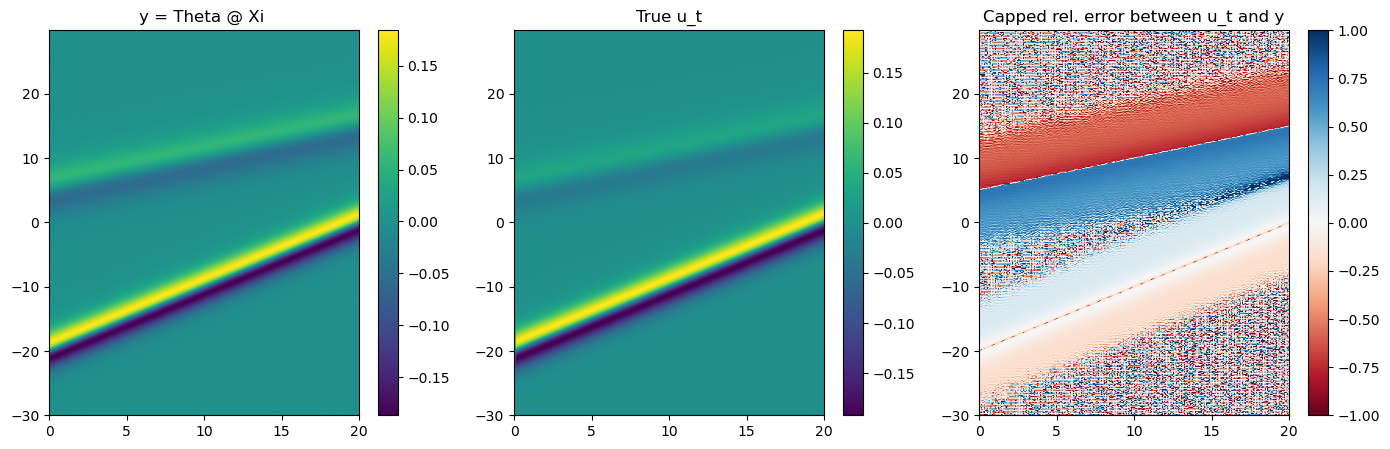

relative error: 0.15614437
L2 error: 2.3978607654571533


In [288]:
# plot
print(Xi)
y = Theta @ Xi
y = y.reshape(X.shape)

# compare the predicted y with the true u_t on two subplots. use the same colourscale for both plots
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

im0 = axs[0].imshow(y,  aspect='auto', origin= 'lower', extent=[t[0], t[-1], x[0], x[-1]])
axs[0].set_title('y = Theta @ Xi ')
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(u_t,  aspect='auto', origin= 'lower', extent=[t[0], t[-1], x[0], x[-1]])
axs[1].set_title('True u_t')
fig.colorbar(im1, ax=axs[1])
#plt.show()


u_t_sliced = u_t[x_slice, t_slice]
# Compute relative error and cap it at 1
rel_l2_capped_at_1 = np.minimum(np.abs((u_t_sliced - y)/(u_t_sliced + 1e-12)), 1) * np.sign(u_t_sliced - y)

im2 = axs[2].imshow(rel_l2_capped_at_1,
           aspect='auto',
           extent=[t[0], t[-1], x[0], x[-1]],
           origin= 'lower',
           cmap='RdBu',    # Set red-blue diverging colormap
           vmin=-1,        # Set minimum of color scale
           vmax=1)         # Set maximum of color scale
axs[2].set_title('Capped rel. error between u_t and y')
fig.colorbar(im2, ax=axs[2])

plt.show()

# print the L2 error of the regression:
l2_error = np.linalg.norm(u_t_sliced - y)
rel_l2_error = l2_error/np.linalg.norm(u_t_sliced)

print("relative error:", rel_l2_error)
print(f"L2 error: {l2_error}")


# Task 3

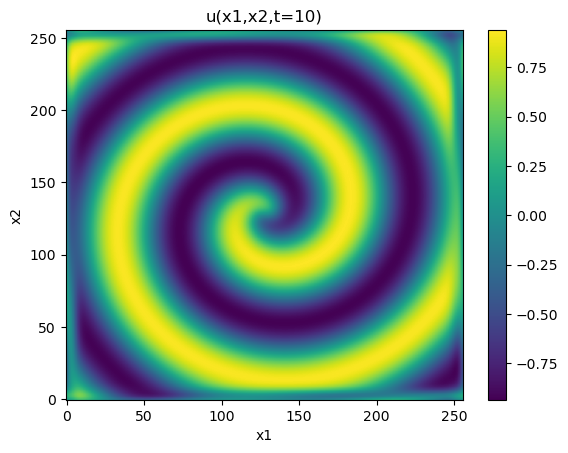

In [300]:
data = np.load('3.npz')

u = data['u']
x = data['x']
t = data['t']



t = t[0, 0 , :]  # Take the first row of x, which should now be shape (101,)
x = x[:, :,  0]  # Take the first column of t, which should now be shape (256,)

dx1 = x[1,0] - x[0,0]
dx2 = x[0,1] - x[0,0]
dt = t[1] - t[0]



dx2 = dx1

# this problem has 2 spacial dimensions so we have to get u_1 and u_2, u_11, u_22, u_12, u_21
# numerical approximation of u_1
u_1 = np.zeros_like(u)

for i in range(1, len(x) - 1):
    for j in range(1, len(x) - 1):
        u_1[i, j, : ] = (u[i+1, j, : ] - u[i-1, j, : ]) / (2 * dx1)

u_1[0, :, :] = (u[1, :, :] - u[0, :, :]) / dx1
u_1[-1, :, :] = (u[-1, :, :] - u[-2, :, :]) / dx1

# numerical approximation of u_2
u_2 = np.zeros_like(u)

for i in range(1, len(x) - 1):
    for j in range(1, len(x) - 1):
        u_2[i, j, : ] = (u[i, j+1, : ] - u[i, j-1, : ]) / (2 * dx2)
        
u_2[:, 0, :] = (u[:, 1, :] - u[:, 0, :]) / dx2
u_2[:, -1, :] = (u[:, -1, :] - u[:, -2, :]) / dx2

# numerical approximation of u_11
u_11 = np.zeros_like(u)
for i in range(1, len(x) - 1):
    for j in range(1, len(x) - 1):
        u_11[i, j, :] = (u[i+1, j, :] - 2 * u[i, j, :] + u[i-1, j, :]) / dx1**2
u_11[0, :, :] = (u[1, :, :] - 2 * u[0, :, :] + u[0, :, :]) / dx1**2
u_11[-1, :, :] = (u[-1, :, :] - 2 * u[-1, :, :] + u[-2, :, :]) / dx1**2

# numerical approximation of u_22
u_22 = np.zeros_like(u)
for i in range(1, len(x) - 1):
    for j in range(1, len(x) - 1):
        u_22[i, j, :] = (u[i, j+1, :] - 2 * u[i, j, :] + u[i, j-1, :]) / dx2**2
u_22[:, 0, :] = (u[:, 1, :] - 2 * u[:, 0, :] + u[:, 0, :]) / dx2**2
u_22[:, -1, :] = (u[:, -1, :] - 2 * u[:, -1, :] + u[:, -2, :]) / dx2**2

# numerical approximation of u_12
u_12 = np.zeros_like(u)
for i in range(1, len(x) - 1):
    for j in range(1, len(x) - 1):
        u_12[i, j, :] = (u[i+1, j+1, :] - u[i+1, j-1, :] - u[i-1, j+1, :] + u[i-1, j-1, :]) / (4 * dx1 * dx2)
u_12[0, :, :] = (u[1, 1, :] - u[1, 0, :] - u[0, 1, :] + u[0, 0, :]) / (dx1 * dx2)
u_12[-1, :, :] = (u[-1, -1, :] - u[-1, -2, :] - u[-2, -1, :] + u[-2, -2, :]) / (dx1 * dx2)

# numerical approximation of u_111
u_111 = np.zeros_like(u)
for i in range(2, len(x) - 1):
    for j in range(1, len(x) - 1):
        u_111[i, j, :] = (u[i+1, j, :] - 3 * u[i, j, :] + 3 * u[i-1, j, :] - u[i-2, j, :]) / dx1**3
u_111[0, :, :] = (u[2, :, :] - 3 * u[1, :, :] + 3 * u[0, :, :] - u[0, :, :]) / dx1**3
u_111[1, :, :] = (u[2, :, :] - 3 * u[1, :, :] + 3 * u[0, :, :] - u[0, :, :]) / dx1**3
u_111[-1, :, :] = (u[-1, :, :] - 3 * u[-1, :, :] + 3 * u[-2, :, :] - u[-3, :, :]) / dx1**3

# numerical approximation of u_222
u_222 = np.zeros_like(u)
for i in range(1, len(x) - 1):
    for j in range(2, len(x) - 1):
        u_222[i, j, :] = (u[i, j+1, :] - 3 * u[i, j, :] + 3 * u[i, j-1, :] - u[i, j-2, :]) / dx2**3
u_222[:, 0, :] = (u[:, 2, :] - 3 * u[:, 1, :] + 3 * u[:, 0, :] - u[:, 0, :]) / dx2**3
u_222[:, 1, :] = (u[:, 2, :] - 3 * u[:, 1, :] + 3 * u[:, 0, :] - u[:, 0, :]) / dx2**3
u_222[:, -1, :] = (u[:, -1, :] - 3 * u[:, -1, :] + 3 * u[:, -2, :] - u[:, -3, :]) / dx2**3

# numerical approximation of u_112
u_112 = np.zeros_like(u)
for i in range(1, len(x) - 1):
    for j in range(1, len(x) - 1):
        u_112[i, j, :] = (u[i+1, j+1, :] - 2 * u[i+1, j, :] + u[i+1, j-1, :] - u[i-1, j+1, :] + 2 * u[i-1, j, :] - u[i-1, j-1, :]) / (4 * dx1 * dx2)
u_112[0, :, :] = (u[1, 1, :] - 2 * u[1, 0, :] + u[1, 0, :] - u[0, 1, :] + 2 * u[0, 0, :] - u[0, 0, :]) / (dx1 * dx2)
u_112[-1, :, :] = (u[-1, -1, :] - 2 * u[-1, -1, :] + u[-1, -2, :] - u[-2, -1, :] + 2 * u[-2, -1, :] - u[-2, -2, :]) / (dx1 * dx2)

u_122 = np.zeros_like(u)
for i in range(1, len(x) - 1):
    for j in range(1, len(x) - 1):
        u_122[i, j, :] = (u[i+1, j+1, :] - 2 * u[i, j+1, :] + u[i-1, j+1, :] - u[i+1, j-1, :] + 2 * u[i, j-1, :] - u[i-1, j-1, :]) / (4 * dx1 * dx2)
u_122[0, :, :] = (u[1, 1, :] - 2 * u[0, 1, :] + u[0, 1, :] - u[1, 0, :] + 2 * u[0, 0, :] - u[0, 0, :]) / (dx1 * dx2)
u_122[-1, :, :] = (u[-1, -1, :] - 2 * u[-1, -1, :] + u[-1, -1, :] - u[-1, -2, :] + 2 * u[-1, -2, :] - u[-1, -2, :]) / (dx1 * dx2)





u_t = np.zeros_like(u)
for i in range(1, len(t) - 1):
    u_t[:, :, i] = (u[:, :, i+1] - u[:, :, i-1]) / (2 * dt)
u_t[:, :, 1] = (u[:, :, 1] - u[:, :, 0]) / dt
u_t[:, :, -1] = (u[:, :, -1] - u[:, :, -2]) / dt



                                                                                

# plot the heat map of u 
plt.imshow(u_t[:, :, 10], origin = 'lower', aspect='auto')
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('u(x1,x2,t=10)')
plt.show()





In [302]:
# Theta generation
def build_library(u, u_1, u_2, u_11, u_22, u_12, u_111, u_222, u_112):
    # Flatten the spatial and temporal dimensions
    
    
    
    u_flat = u.flatten()
    u_1_flat = u_1.flatten()
    u_2_flat = u_2.flatten()
    u_11_flat = u_11.flatten()
    u_22_flat = u_22.flatten()
    u_12_flat = u_12.flatten()
    u_111_flat = u_111.flatten()
    u_222_flat = u_222.flatten()
    u_112_flat = u_112.flatten()
        
    library = np.vstack([
        u_flat,          # Linear term: u
        u_1_flat,        # u_x
        u_2_flat,        # u_y
        u_11_flat,       # u_xx
        u_22_flat,       # u_yy
        u_12_flat,       # u_xy
        u_111_flat,      # u_xxx
        u_222_flat,      # u_yyy
        u_112_flat,      # u_xyy
        u_flat ** 2,     # Nonlinear term: u^2
        u_flat * u_1_flat,  # u * u_x
        u_flat * u_2_flat,  # u * u_y
        u_1_flat * u_2_flat, # u_x * u_y
        u_1_flat ** 2,   # u_x^2
        u_2_flat ** 2,   # u_y^2
        u_11_flat ** 2,  # u_xx^2
        u_22_flat ** 2,  # u_yy^2
        u_12_flat ** 2,  # u_xy^2
        u_111_flat ** 2, # u_xxx^2
        u_222_flat ** 2, # u_yyy^2
        u_112_flat ** 2, # u_xyy^2
        u_flat * u_11_flat,  # u * u_xx
        u_flat * u_22_flat,  # u * u_yy
        u_flat * u_12_flat,  # u * u_xy
    ]).T  # Transpose to make it samples x features
    
    return library

u_t_flat = u_t.flatten() # target

# build the library
library = build_library(u, u_1, u_2, u_11, u_22, u_12, u_111, u_222, u_112) 





In [304]:
# lasso
# perfrom lasso (takes a while)
alpha = 1e-4
lasso2 = Lasso(alpha=alpha, fit_intercept=False)
lasso2.fit(library, u_t_flat)

Xi = lasso.coef_
print("Coefficients:")
for term, coeff in zip(terms, Xi):
    print(f"{term}: {coeff}")
    

KeyboardInterrupt: 

In [303]:

# perform thresholding
threshold = 1e-3

# initial ridge
alpha = 1e-1  # HIGH regularization!
ridge = Ridge(alpha=alpha, fit_intercept=False)
ridge.fit(Theta, Ut_flat)

Xi = ridge.coef_.ravel()
print("Initial coefficients:")
for term, coeff in zip(terms, Xi):
    print(f"{term}: {coeff}")


def threshold_coeffs(Xi, threshold):
    # Set coefficients smaller than threshold in absolute value to zero
    Xi[np.abs(Xi) < threshold] = 0
    return Xi

threshold = 1e-1
Xi_old = Xi.copy()
for _ in range(10): 
    Xi = threshold_coeffs(Xi, threshold)
    # Refit only with non-zero coefficients
    keep_terms = Xi != 0
    if np.sum(keep_terms) == 0:
        break
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(Theta[:, keep_terms], Ut_flat)
    Xi_new = np.zeros_like(Xi)
    Xi_new[keep_terms] = ridge.coef_.ravel()
    # Check for convergence
    if np.allclose(Xi_new, Xi, atol=1e-8):
        break
    Xi = Xi_new

print("\nCoefficients after thresholding:")
for term, coeff in zip(terms, Xi):
    print(f"{term}: {coeff}")
    
Xi_2d_ridge = Xi


Initial coefficients:
u: -7.179161912063137e-05
u_x: -0.0006034164689481258
u_y: -0.4137529134750366
u_xx: 0.010427207686007023
u_yy: -0.45002198219299316
u_xy: 0.006308148615062237
u_xxx: -0.012377374805510044
u_yyy: 0.095807284116745
u_xyy: -0.062423914670944214
u^2: -2.093836545944214
u * u_x: 0.019973982125520706
u * u_y: 0.9858320355415344
u_x * u_y: -2.4233977794647217
u_x^2: -0.11253903061151505
u_y^2: -0.12864121794700623

Coefficients after thresholding:
u: 0.0
u_x: 0.0
u_y: -0.41522666811943054
u_xx: 0.0
u_yy: -0.4474342167377472
u_xy: 0.0
u_xxx: 0.0
u_yyy: 0.0
u_xyy: 0.0
u^2: -2.0938735008239746
u * u_x: 0.0
u * u_y: 0.9767242074012756
u_x * u_y: -2.3999035358428955
u_x^2: 0.0
u_y^2: -0.11721797287464142


In [306]:
#  # lasso for this task: 
# # Get the coefficients
# coefficients = lasso2.coef_

# # Threshold the coefficients (will artificaially set some coefficients to zero)
# threshold = 1e-3
# sparse_coefficients = coefficients * (np.abs(coefficients) > threshold)

# # 4. Display the discovered PDE
# terms = [
#     "u", "u_x", "u_y", "u_xx", "u_yy", "u_xy", "u_xxx", "u_yyy", "u_xyy",
#     "u^2", "u * u_x", "u * u_y", "u_x * u_y", "u_x^2", "u_y^2", "u_xx^2", "u_yy^2", "u_xy^2", "u_xxx^2", "u_yyy^2", "u_xyy^2",
#     "u * u_xx", "u * u_yy", "u * u_xy"
# ]

# print("Discovered PDE:")
# print("u_t = ", end="")
# for coef, term in zip(sparse_coefficients, terms):
#     if coef != 0:
#         print(f"{coef:.4f} * {term} + ", end="")
# print("0")

# y = library @ coefficients
# y = y.reshape(u.shape)


# time_stamp = 100

# plt.imshow(y[:, :, time_stamp], aspect='auto')
# plt.colorbar()
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('y = Theta @ Xi ')
# plt.show()

# # plot the heat map of u_t
# plt.imshow(u_t[:, :, time_stamp], aspect='auto')
# plt.colorbar()
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('u_t')
# plt.show()


# # plot the difference between u_t and y
# plt.imshow((u_t[:, :, time_stamp] - y[:, :, time_stamp])/(u_t[:, :, time_stamp] + 1e-8), aspect='auto')
# plt.colorbar()
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('difference between u_t and y')
# plt.show()



# # compute the l2 error between u_t and y
# l2_error = np.sqrt(np.mean((u_t_flat - y.flatten())**2))
# print(f"L2 error: {l2_error:.2e}")

# print("relative L2 error: ", l2_error/np.sqrt(np.mean(u_t_flat**2)))


